<a href="https://colab.research.google.com/github/Aditya-Walia1/ML-Assignments/blob/main/Link_Prediction_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Introduction**
This code implements a **link prediction problem** using **Random Forests** and **Logistic Regression with Regularization** on a graph dataset (`fb-forum.txt`). The goal is to predict whether a link (edge) exists between two nodes in a graph based on various graph-based and embedding-based features.

---

### **2. Loading and Preparing the Dataset**
1. **Dataset Loading**:
   - The dataset contains three columns: `Source`, `Target`, and `Timestamp`, representing edges (links) in a graph.
   - We convert the `Timestamp` column into a human-readable datetime format for further analysis.

2. **Graph Construction**:
   - Using `NetworkX`, a graph is constructed where `Source` and `Target` nodes form edges.

3. **Positive and Negative Samples**:
   - **Positive Samples**: Existing edges in the graph.
   - **Negative Samples**: Randomly sampled node pairs without edges, ensuring no overlap with existing links.

   This creates a balanced dataset for supervised learning, where each sample has a binary label (`1` for existing links and `0` for non-existing links).

---

### **3. Feature Engineering**
We extract various features to characterize the relationship between pairs of nodes:

1. **Graph-Based Features**:
   - Degree of source and target nodes.
   - Number of common neighbors.
   - Jaccard Coefficient.
   - Clustering Coefficients.
   - Adamic-Adar Index.
   - Resource Allocation Index.
   - Preferential Attachment score.

2. **Centrality Measures**:
   - Katz, Betweenness, Eigenvector, Closeness centralities, and PageRank scores for both nodes in each pair.

3. **Node2Vec Embeddings**:
   - Learned embeddings for each node using random walks, capturing structural similarity.

4. **Feature Vector Construction**:
   - A function combines these features for every node pair in the dataset.
   - The resulting DataFrame has rows corresponding to node pairs and columns representing features.

---

### **4. Data Preprocessing**
1. **Scaling Features**:
   - Features are scaled to the range `[0, 1]` using `MinMaxScaler`.

2. **Handling Imbalanced Classes**:
   - **SMOTE (Synthetic Minority Oversampling Technique)** is used to balance the dataset, generating synthetic samples for the minority class.

3. **Correlation Analysis**:
   - A **correlation matrix** identifies highly correlated features (above a threshold of `0.85`).
   - Redundant features are removed to prevent multicollinearity, reducing the feature set.

---

### **5. Model Training and Evaluation**
1. **Models Used**:
   - **Random Forest Classifier**: Trained on the reduced feature set.
  

2. **Metrics Evaluated**:
   - **Accuracy**: Correct predictions over total predictions.
   - **Precision**: True positives over predicted positives.
   - **Recall**: True positives over actual positives.
   - **F1 Score**: Harmonic mean of precision and recall.
   - **Confusion Matrix**: Visualizes model predictions (TP, FP, FN, TN).

---

### **6. Feature Importance**
- The Random Forest model provides feature importances, highlighting the most influential features for link prediction.
- The top 15 features are visualized to interpret the model's decision-making process.

---

### **7. Key Insights**
1. **Correlation Matrix**:
   - Highly correlated features were removed, reducing redundancy and improving model performance.

2. **Regularization**:
   - Logistic Regression with L1 penalty improved interpretability by selecting only significant features.

3. **Performance Comparison**:
   - Both Random Forest and Logistic Regression models were evaluated after preprocessing, showing improved results.

4. **Feature Importance**:
   - Random Forest highlighted key features like `common_neighbors`, `node2vec_similarity`, and `degree_source`.

---

### **8. Summary**
- This approach combines **graph theory**, **node embeddings**, and **machine learning** for link prediction.
- Preprocessing steps like **scaling**, **SMOTE**, and **regularization** enhanced the model's reliability and interpretability.
- The methodology is modular, allowing easy addition of new features or testing with different classifiers.


Computing transition probabilities:   0%|          | 0/899 [00:00<?, ?it/s]

Accuracy: 0.9409
Precision: 0.9316
Recall: 0.9517
F1 Score: 0.9415


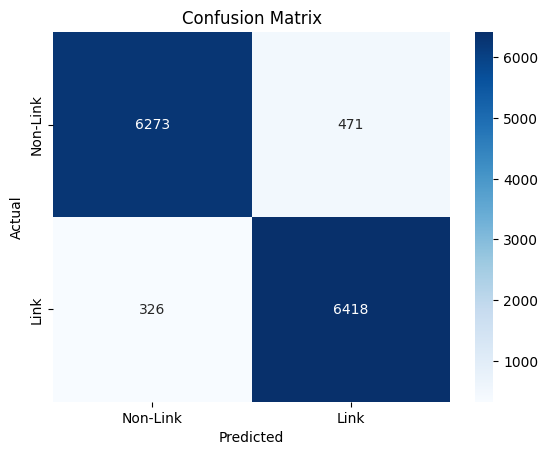

In [14]:
# Install necessary packages
!pip install networkx node2vec python-louvain imbalanced-learn optuna shap scikit-learn matplotlib seaborn lightgbm

# Import necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from node2vec import Node2Vec

# Load the dataset
file_path = '/content/fb-forum.txt'
df = pd.read_csv(file_path, sep="\s+", header=None, names=['Source', 'Target', 'Timestamp'])

# Convert the Timestamp to a proper datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Create a graph from the Source-Target pairs
G = nx.from_pandas_edgelist(df, source='Source', target='Target', create_using=nx.Graph())

# Create positive samples (existing links)
positive_samples = df[['Source', 'Target']].copy()
positive_samples['Label'] = 1  # Label for existing links

# Generate negative samples (non-existing links)
all_nodes = list(G.nodes())
negative_samples = []
num_samples = len(positive_samples)

while len(negative_samples) < num_samples:
    source = np.random.choice(all_nodes)
    target = np.random.choice(all_nodes)
    if source != target and not G.has_edge(source, target):
        negative_samples.append([source, target])

negative_samples_df = pd.DataFrame(negative_samples, columns=['Source', 'Target'])
negative_samples_df['Label'] = 0  # Label for non-existing links

# Combine positive and negative samples
dataset = pd.concat([positive_samples, negative_samples_df], ignore_index=True)

# Precompute centralities for the graph
centrality_measures = {
    'katz_centrality': nx.katz_centrality_numpy(G, alpha=0.005),
    'betweenness_centrality': nx.betweenness_centrality(G),
    'eigenvector_centrality': nx.eigenvector_centrality_numpy(G),
    'pagerank': nx.pagerank(G),
    'closeness_centrality': nx.closeness_centrality(G),
}

# Generate Node2Vec embeddings
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
n2v_model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Feature extraction function
def extract_features(source, target):
    features = {
        'degree_source': G.degree[source],
        'degree_target': G.degree[target],
        'common_neighbors': len(list(nx.common_neighbors(G, source, target))),
    }

    # Add additional features with error handling for missing centralities
    try:
        for name, centrality in centrality_measures.items():
            features[f'{name}_source'] = centrality[source]
            features[f'{name}_target'] = centrality[target]
    except KeyError:
        pass

    # Node2Vec Embeddings similarity
    default_embedding = np.zeros(n2v_model.wv.vector_size)
    source_embedding = n2v_model.wv[source] if source in n2v_model.wv else default_embedding
    target_embedding = n2v_model.wv[target] if target in n2v_model.wv else default_embedding
    features['node2vec_similarity'] = np.dot(source_embedding, target_embedding)

    return features

# Create feature DataFrame
features_list = []
for _, row in dataset.iterrows():
    features = extract_features(row['Source'], row['Target'])
    features['Label'] = row['Label']
    features_list.append(features)

features_df = pd.DataFrame(features_list)

# Handle missing values and scale features
features_df.fillna(0, inplace=True)
X = features_df.drop('Label', axis=1)
y = features_df['Label']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Balance classes using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Link", "Link"], yticklabels=["Non-Link", "Link"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


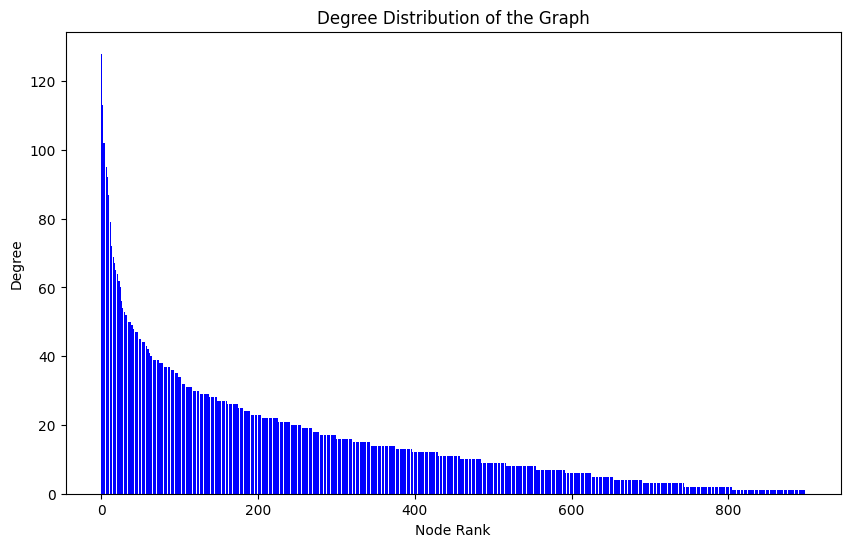

<ipython-input-15-11038ab57dd8>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=dataset, palette='viridis')


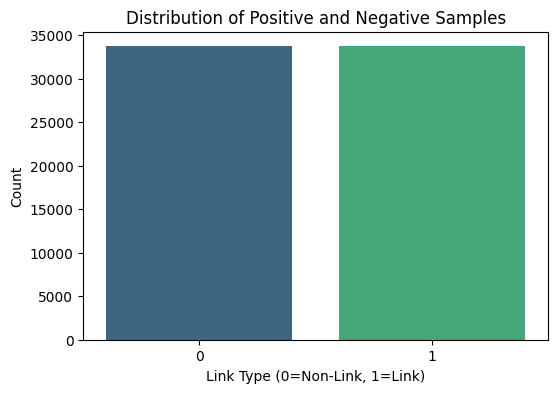

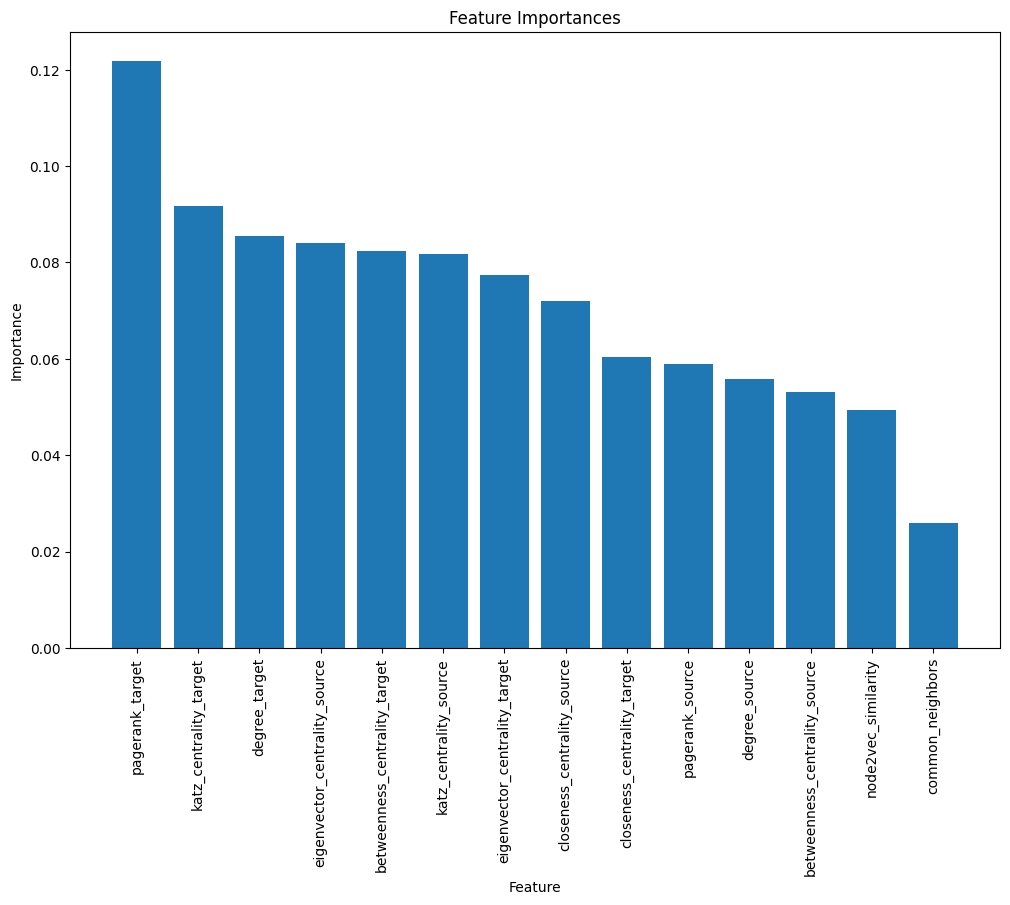

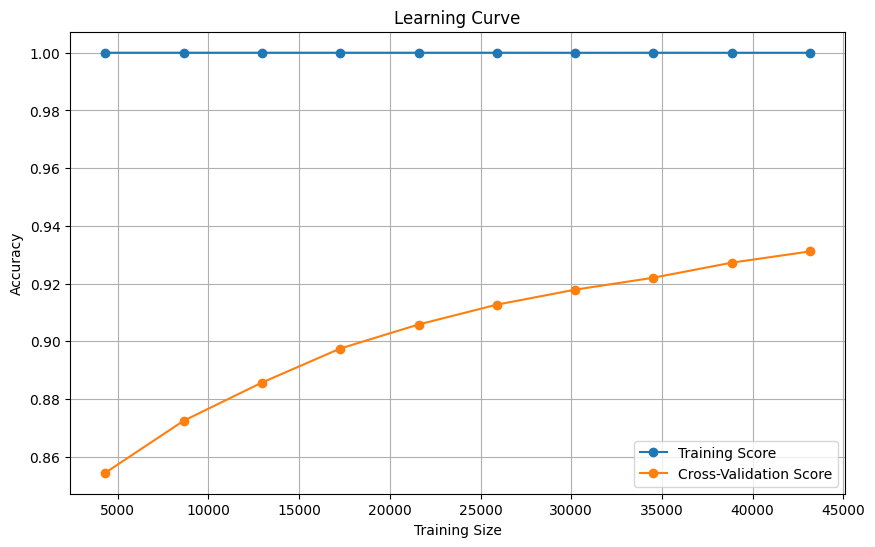

In [15]:

# Plot the distribution of positive and negative samples
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=dataset, palette='viridis')
plt.title("Distribution of Positive and Negative Samples")
plt.xlabel("Link Type (0=Non-Link, 1=Link)")
plt.ylabel("Count")
plt.show()

# Plot the feature importance from Random Forest
importances = rf_classifier.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.title("Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

# Plot a learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Cross-Validation Score", marker='o')
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


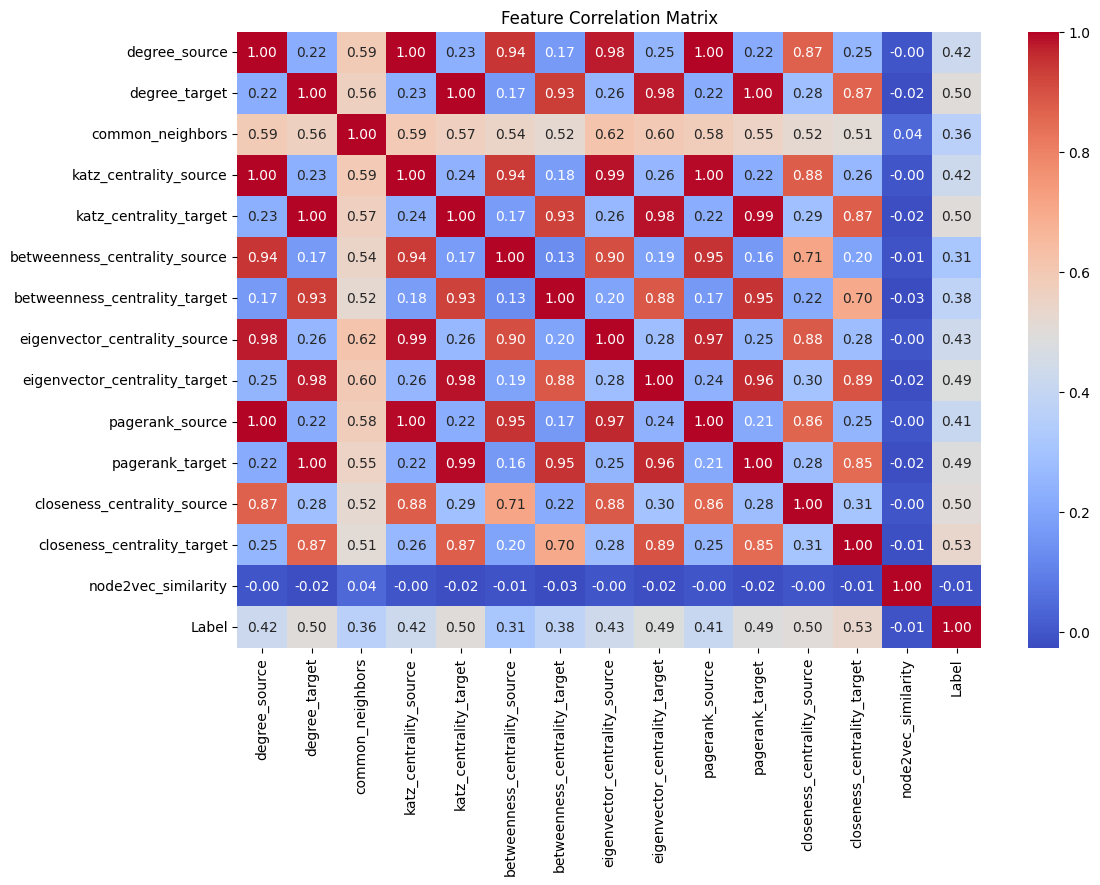

Highly correlated feature pairs (>|0.85|): [('degree_source', 'katz_centrality_source'), ('degree_source', 'betweenness_centrality_source'), ('degree_source', 'eigenvector_centrality_source'), ('degree_source', 'pagerank_source'), ('degree_source', 'closeness_centrality_source'), ('degree_target', 'katz_centrality_target'), ('degree_target', 'betweenness_centrality_target'), ('degree_target', 'eigenvector_centrality_target'), ('degree_target', 'pagerank_target'), ('degree_target', 'closeness_centrality_target'), ('katz_centrality_source', 'degree_source'), ('katz_centrality_source', 'betweenness_centrality_source'), ('katz_centrality_source', 'eigenvector_centrality_source'), ('katz_centrality_source', 'pagerank_source'), ('katz_centrality_source', 'closeness_centrality_source'), ('katz_centrality_target', 'degree_target'), ('katz_centrality_target', 'betweenness_centrality_target'), ('katz_centrality_target', 'eigenvector_centrality_target'), ('katz_centrality_target', 'pagerank_targe

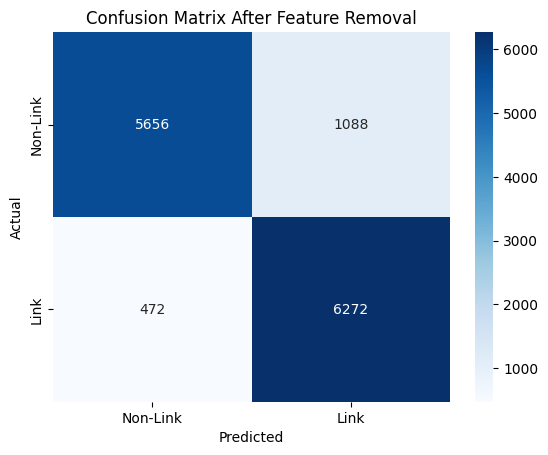

In [16]:
# Plot the correlation matrix
correlation_matrix = features_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

# Identify highly correlated features (correlation > 0.85 or < -0.85)
threshold = 0.85
high_corr_pairs = [(i, j) for i in correlation_matrix.columns for j in correlation_matrix.columns
                   if i != j and abs(correlation_matrix.loc[i, j]) > threshold]
print(f"Highly correlated feature pairs (>|{threshold}|): {high_corr_pairs}")

# Remove one feature from each highly correlated pair
features_to_remove = set()
for i, j in high_corr_pairs:
    # Remove the second feature in each pair to avoid redundancy
    features_to_remove.add(j)

# Drop the correlated features
X_reduced = features_df.drop(list(features_to_remove) + ['Label'], axis=1)

# Scale and split the data again
X_scaled_reduced = scaler.fit_transform(X_reduced)
X_resampled_reduced, y_resampled_reduced = smote.fit_resample(X_scaled_reduced, y)
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_resampled_reduced, y_resampled_reduced, test_size=0.2, random_state=42, stratify=y_resampled_reduced
)

# Retrain the Random Forest model
rf_classifier_reduced = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier_reduced.fit(X_train_reduced, y_train_reduced)

# Evaluate the model after feature removal
y_pred_reduced = rf_classifier_reduced.predict(X_test_reduced)
accuracy_reduced = accuracy_score(y_test_reduced, y_pred_reduced)
precision_reduced = precision_score(y_test_reduced, y_pred_reduced)
recall_reduced = recall_score(y_test_reduced, y_pred_reduced)
f1_reduced = f1_score(y_test_reduced, y_pred_reduced)

print("\nModel Performance After Feature Removal:")
print(f"Accuracy: {accuracy_reduced:.4f}")
print(f"Precision: {precision_reduced:.4f}")
print(f"Recall: {recall_reduced:.4f}")
print(f"F1 Score: {f1_reduced:.4f}")

# Plot the updated confusion matrix
conf_matrix_reduced = confusion_matrix(y_test_reduced, y_pred_reduced)
sns.heatmap(conf_matrix_reduced, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Link", "Link"], yticklabels=["Non-Link", "Link"])
plt.title("Confusion Matrix After Feature Removal")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
